In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Importar librerías


In [3]:
import janitor
import nhanes.load
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

## Importar funciones personalizadas


In [4]:
%run ../imputacion_packages/utils/pandas-missing-extension.py

## Cargar los datos de NHANES

Dataset: [National Health and Nutrition Examination Survey](https://wwwn.cdc.gov/nchs/nhanes/tutorials/default.aspx)


In [5]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year="2017-2018").clean_names(
    case_type="snake"
)

nhanes_raw_df

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


## Procesar los datos de NHANES


In [6]:
nhanes_df = (
    nhanes_raw_df.loc[
        :,
        [
            "general_health_condition",
            "age_in_years_at_screening",
            "gender",
            "current_selfreported_height_inches",
            "current_selfreported_weight_pounds",
            "doctor_told_you_have_diabetes",
            "60_sec_pulse30_sec_pulse2",
            "total_cholesterol_mgdl",
        ],
    ]
    .rename(
        columns={
            "age_in_years_at_screening": "age",
            "current_selfreported_height_inches": "height",
            "current_selfreported_weight_pounds": "weight",
            "doctor_told_you_have_diabetes": "diabetes",
            "60_sec_pulse30_sec_pulse2": "pulse",
            "total_cholesterol_mgdl": "cholesterol",
        }
    )
    .replace(
        {
            "height": {9999: np.nan, 7777: np.nan},
            "weight": {9999: np.nan, 7777: np.nan},
            "diabetes": {"Borderline": np.nan},
        }
    )
    .dropna(subset=["diabetes"])
    .assign(diabetes=lambda x: x.diabetes.astype(int))
)
nhanes_df

,general_health_condition,age,gender,height,weight,diabetes,pulse,cholesterol
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,4.0,Male,NaN,NaN,0,NaN,NaN
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


In [7]:
nhanes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8187 entries, 93703.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   general_health_condition  5797 non-null   object 
 1   age                       8187 non-null   float64
 2   gender                    8187 non-null   object 
 3   height                    5488 non-null   float64
 4   weight                    5553 non-null   float64
 5   diabetes                  8187 non-null   int32  
 6   pulse                     6570 non-null   float64
 7   cholesterol               6565 non-null   float64
dtypes: float64(5), int32(1), object(2)
memory usage: 543.7+ KB


## Visualizar los valores faltantes


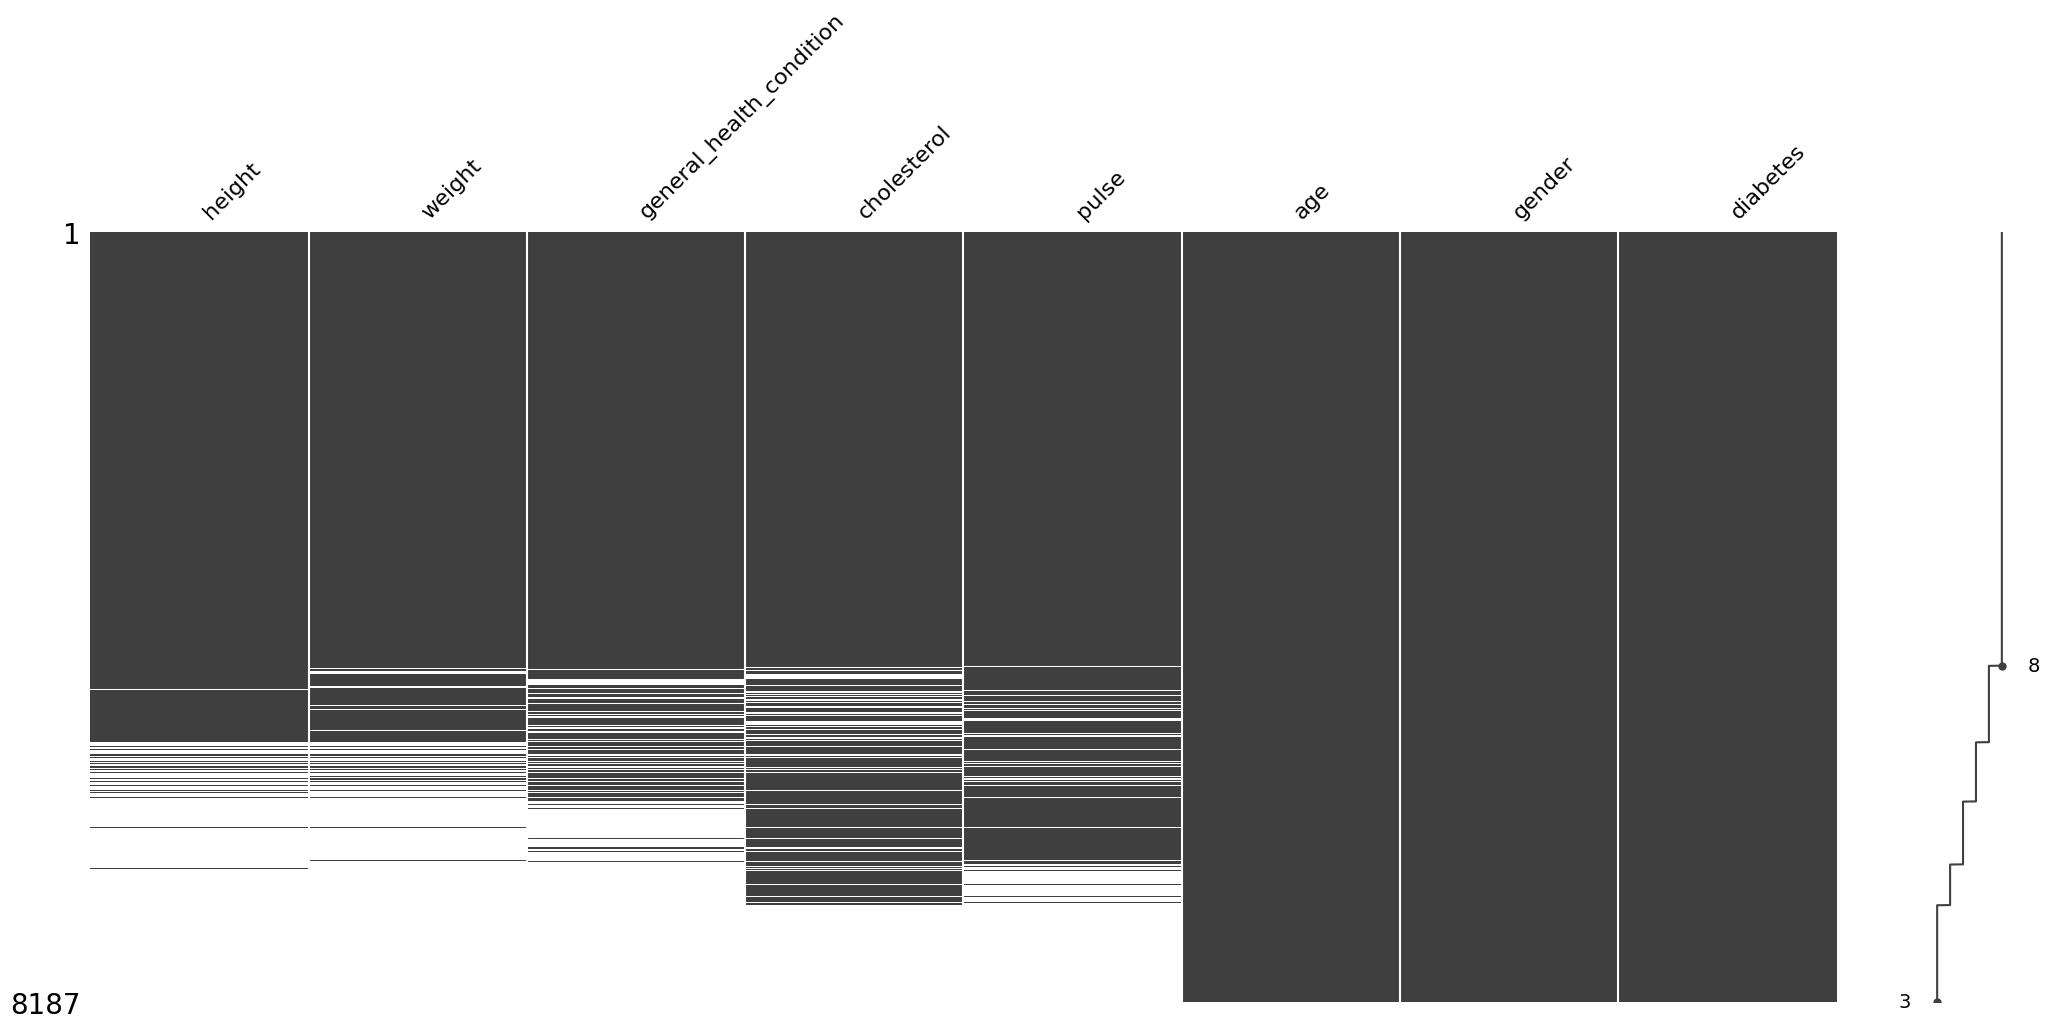

In [8]:
nhanes_df.missing.sort_variables_by_missingness().pipe(msno.matrix, sort="descending")
plt.show()

c:\Users\mike\Documents\datos\imputacion\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\mike\Documents\datos\imputacion\venv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

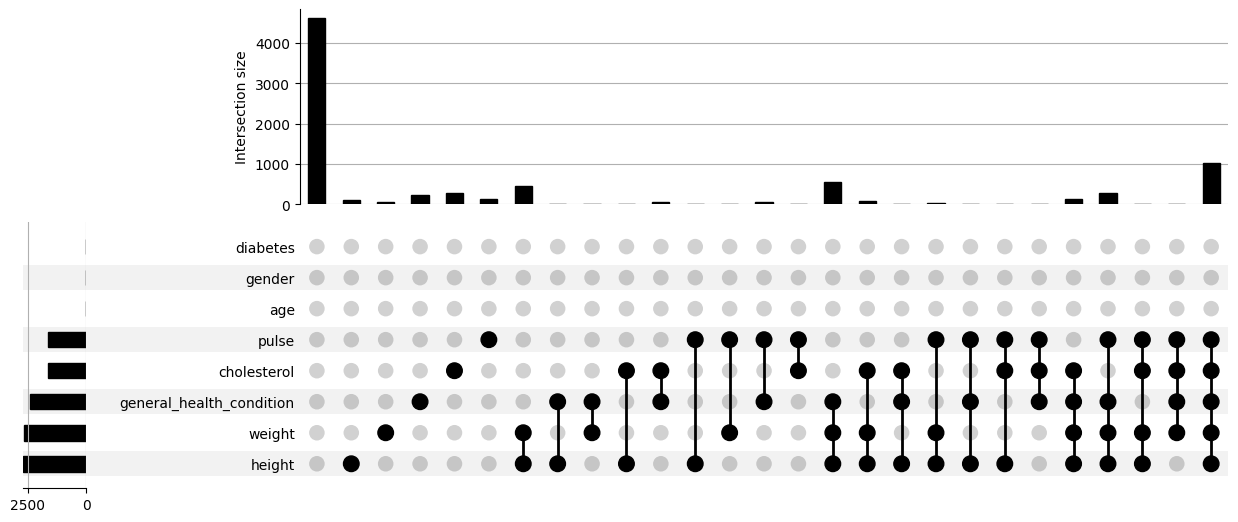

In [9]:
nhanes_df.missing.sort_variables_by_missingness().missing.missing_upsetplot()
plt.show()

La función `missingno.matrix()` te permite visualizar la nulidad de tu conjunto de datos en forma de matriz


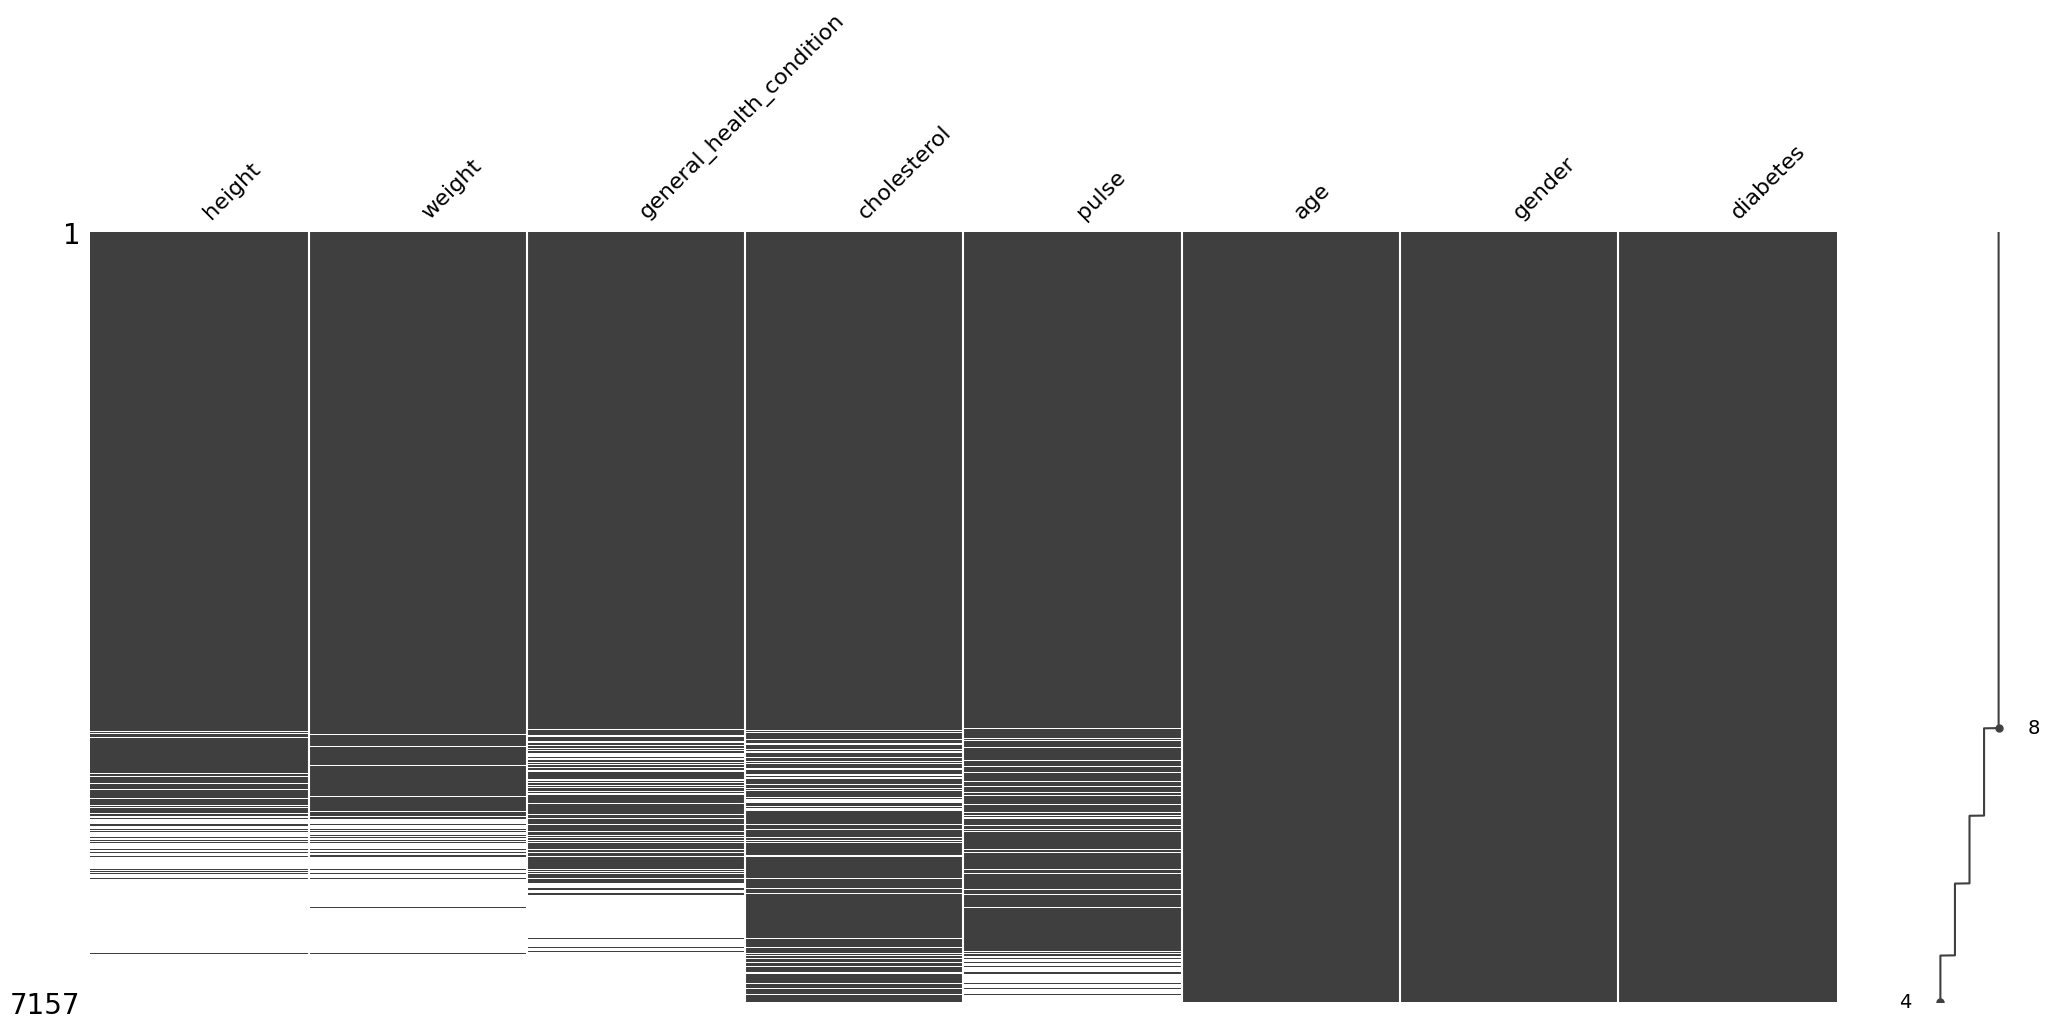

In [10]:
nhanes_df.dropna(
    subset=["pulse", "cholesterol", "general_health_condition", "weight", "height"],
    how="all",
).missing.sort_variables_by_missingness().pipe(msno.matrix, sort="descending")
plt.show()

## Eliminar valores faltantes


In [11]:
nhanes_df = nhanes_df.dropna(
    subset=["pulse", "cholesterol", "general_health_condition", "weight", "height"],
    how="all",
).missing.sort_variables_by_missingness()

In [12]:
nhanes_df.shape

(7157, 8)

Se han perdido 1209 puntos de datos respecto al dataset original
